In [74]:
sums = []

In [75]:
import random
from itertools import combinations, combinations_with_replacement, permutations
import numpy as np

def init():
    # Initialize scoreboard, textfields, freefields and decisionlists
    scoreboard = [None] * 21
    textfields = ["Name    ", "Ones    ", "Twos    ", "Threes  ", "Fours   ",\
        "Fives   ", "Sixes   ", "Sum     ", "Bonus   ", "Total 1 ",\
        "One pair", "Two pairs", "Triple  ", "Quadruple", "Full house",\
        "Small straigth", "Big straight", "Kniffel ", "Chance  ", "Total 2 ",\
        "Total   "] # Text for prints
    freefields = [1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    maxpoints = [5, 10, 15, 20, 25, 30, 12, 22, 18, 24, 30, 25, 40, 50, 30] 
    optimizer = [0.7, 0.8, 1, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 1, 1, 0.5]
    return scoreboard, textfields, freefields, maxpoints,  optimizer

def first_roll(n=5, k=6):
    # Generate random integers for the first roll
    return sorted((random.randint(1, k) for _ in range(n)))

def update_scoreboard(scoreboard, field, points):
    # Update the score for the given field
    if scoreboard[field] is None:
        scoreboard[field] = points
    else:
        scoreboard[field] += points
    return scoreboard

def update_freefields(freefields, field):
    # Update the list of free fields
    freefields.remove(field)
    return freefields
    
def calculate_scores(fields):
    # Calculate the sum, bonus, and total scores based on the individual fields
    fields[7] = sum(fields[1:7])
    if fields[7] >= 63:
        fields[8] = 37
    else:
        fields[8] = 0
    fields[9] = fields[7] + fields[8]
    fields[19] = sum(fields[10:19])
    fields[20] = fields[9] + fields[19]
    return fields

def writename(name, fields):
    # Write the name of the player
    fields[0] = name
    return fields

def calc_score_1_to_6(values, field):
    # Calculate the score for scoreboard indices 1 to 6: ones till sixes
    return sum(value for value in values if value == field)

def calc_score_10(values):
    # Calculate the score for scoreboard index 10: one pair
    pairs = []
    for value in set(values):
        if values.count(value) >= 2:
            pairs.append(value)
    if pairs:
        highest_pair = max(pairs)
        return highest_pair * 2
    else:
        return 0
    
def calc_score_11(values):
    # Calculate the score for scoreboard index 11: two pairs
    pairs = []
    for value in set(values):
        if values.count(value) >= 2:
            pairs.append(value)
    if len(pairs) >= 2:
        return sum(pairs) * 2
    else:
        return 0
    
def calc_score_12(values):
    # Calculate the score for scoreboard index 12: three of a kind
    for value in set(values):
        if values.count(value) >= 3:
            return value * 3
    return 0

def calc_score_13(values):
    # Calculate the score for scoreboard index 13: four of a kind
    for value in set(values):
        if values.count(value) >= 4:
            return value * 4
    return 0

def calc_score_14(values):
    # Calculate the score for scoreboard index 14: full house
    for value in set(values):
        if values.count(value) == 3:
            for value2 in set(values):
                if value2 != value and values.count(value2) == 2:
                    return 30
    return 0

def calc_score_15(values):
    # Calculate the score for scoreboard index 15: small street
    if set(values) in [{1, 2, 3, 4}, {2, 3, 4, 5}, {3, 4, 5, 6}]:
        return 25
    else:
        return 0
    
def calc_score_16(values):
    # Calculate the score for scoreboard index 16: big street
    if set(values) in [{1, 2, 3, 4, 5}, {2, 3, 4, 5, 6}]:
        return 40
    else:
        return 0
    
def calc_score_17(values):
    # Calculate the score for scoreboard index 17: kniffel
    for value in set(values):
        if values.count(value) == 5:
            return 50
    return 0

def calc_score_18(values):
    # Calculate the score for scoreboard index 18: chance
    return sum(values)

def calc_score_field(values, field):
    # Calculate the score for the given values and field
    match field:
        case 1:     # Ones 
            return calc_score_1_to_6(values, 1)
        case 2:     # Twos
            return calc_score_1_to_6(values, 2)
        case 3:     # Threes
            return calc_score_1_to_6(values, 3)
        case 4:     # Fours
            return calc_score_1_to_6(values, 4)
        case 5:     # Fives    
            return calc_score_1_to_6(values, 5)
        case 6:     # Sixes
            return calc_score_1_to_6(values, 6)
        case 10:    # One pair
            return calc_score_10(values)
        case 11:    # Two pairs
            return calc_score_11(values)
        case 12:    # Three of a kind
            return calc_score_12(values)
        case 13:    # Four of a kind
            return calc_score_13(values)
        case 14:    # Full house
            return calc_score_14(values)
        case 15:    # Small street
            return calc_score_15(values)
        case 16:    # Big street
            return calc_score_16(values)
        case 17:    # Kniffel
            return calc_score_17(values)
        case 18:    # Chance
            return calc_score_18(values)
        case _:     # Invalid field
            raise TypeError("Invalid field")

def get_states(n=5, k=6):
    # Calculate possible states of n dice with k sides
    states = []
    dice = range(1, k+1)  
    for state in combinations_with_replacement(dice, n):
        states.append(state)
    return states

def get_combinations(state):
    # Get all rerolls of the state
    rerolls = []
    for length in range(len(state) + 1):
        for combination in combinations(state, length):
            if combination not in rerolls:
                rerolls.append(combination)
    return rerolls

def get_reroll_state_propability(state, rerolls, states, n=5, k=6):
    # Calculate propabilities for each state after rerolling
    propability = np.ones((len(rerolls), len(states)))
    propability[0,:] = 0
    state = tuple(state)
    for i, reroll in enumerate(rerolls[:-1]): 
        if len(reroll) == 0:
            propability[i,states.index(state)] = 1
        else:
            keep_dice = list(state)
            for value in reroll:
                keep_dice.remove(value)
            for s in states:
                reach_dice = list(s)
                for element in keep_dice:
                    try:
                        reach_dice.remove(element)
                    except ValueError:
                        propability[i,states.index(s)] = 0
                        break 
                if propability[i,states.index(s)] != 0:
                    variants = set(permutations(reach_dice, len(reach_dice)))
                    propability[i,states.index(s)] = (1/k)**len(reach_dice)*len(variants)
    for s in states:
        variants = set(permutations(s, n))
        propability[-1,states.index(s)] = (1/k)**n*len(variants)
    return propability

def collect_decision_parameters(input_state, fields, maxpoints, optimizer, n=5, k=6):
    states = get_states(n, k)
    rerolls = get_combinations(input_state)
    propabilities = get_reroll_state_propability(input_state, rerolls, states)
    decision_score_matrix = np.zeros_like(propabilities)
    decision_score = np.zeros(len(rerolls))
    for i, reroll in enumerate(rerolls):
        for j, state in enumerate(states):
            if propabilities[i,j] != 0:
                potential_points = 0
                for field in fields:
                    currentpoints = calc_score_field(state, field)
                    potential_points += calculate_potential(currentpoints, maxpoints, field, optimizer)
                decision_score_matrix[i,j] = potential_points * propabilities[i,j]
        decision_score[i] = np.sum(decision_score_matrix[i,:])
    index = np.argmax(decision_score)
    return rerolls[index]

def reroll_state(state, reroll_dice, n=5, k=6):
    new_roll = list(state)
    for element in reroll_dice:
        new_roll.remove(element)
    while len(new_roll) < n:
        new_roll.append(random.randint(1, k))
    rerolled_state = tuple(sorted(tuple(new_roll)))
    return rerolled_state

def find_best_score(freefields, roll, maxpoints, optimizer):
    # Find the best score for the given roll, output points and field
    current_points = np.zeros(len(freefields))
    potential_points = np.zeros(len(freefields))
    for i, field in enumerate(freefields):
        points = calc_score_field(roll, field)
        current_points[freefields.index(field)] = points
        potential_points[i] += calculate_potential(points, maxpoints, field, optimizer)
    index = np.argmax(potential_points)
    return int(current_points[index]), freefields[index]
    
def run_game(name, throws=3, n=5, k=6, printscoreboard=True, printinfo=False, randomseed=False):
    if randomseed:
        random.seed(randomseed)
    if printinfo:
        print("Game with", throws, "throw(s) per round and" ,n, "dice with", k, "sides.")
    scoreboard, textfields, freefields, maxpoints, optimizer = init()
    writename(name, scoreboard)
    count_round = 0
    while count_round < 15:
        count_round += 1
        roll = first_roll(n, k)
        if printinfo:
            print("Round", count_round, ":", roll)
        for i in range(throws-1):
            reroll_dice = collect_decision_parameters(roll, freefields, maxpoints, optimizer)
            roll = reroll_state(roll, reroll_dice)
            if printinfo:
                print("Reroll", i+1, ":", roll, "Rerolled:", reroll_dice)
        writepoints, field = find_best_score(freefields, roll, maxpoints, optimizer) # field = freefields[index]
        if printinfo:
            print("Wrote", writepoints, "to", textfields[field])
        scoreboard = update_scoreboard(scoreboard, field, writepoints)
        if writepoints == 50:
            if scoreboard[field] > 50:
                kniffelindex = freefields.index(17)
                writepoints, field = find_best_score(freefields[:kniffelindex] + freefields[kniffelindex+1:], roll, maxpoints, optimizer)
                if printinfo:
                    print("Wrote", writepoints, "to", textfields[field])
                scoreboard = update_scoreboard(scoreboard, field, writepoints)
                freefields = update_freefields(freefields, field)
        else:
            freefields = update_freefields(freefields, field)
        
    scoreboard = calculate_scores(scoreboard)  
    if printscoreboard:  
        for i,j in enumerate(scoreboard):
            print(textfields[i]+"\t", j)
    return scoreboard[20]

def calculate_potential(currentpoints, maxpoints, field, optimizer):
    if field > 6:
        field = field - 3
    return currentpoints**2 / (maxpoints[field-1]**1) * optimizer[field-1]

n = 30000
for i in range(n):
    sums.append(run_game("Test", 3, printinfo=False, printscoreboard=False))

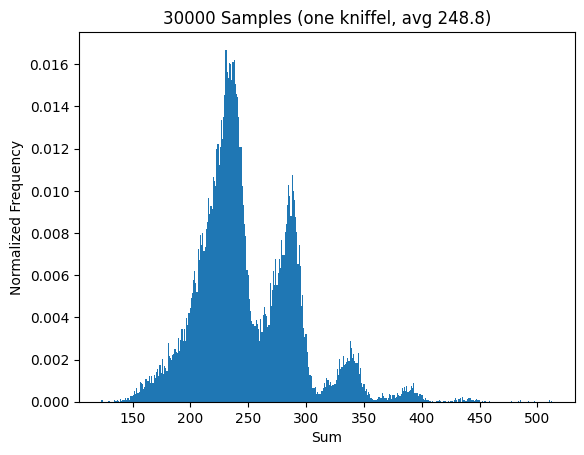

In [92]:
import matplotlib.pyplot as plt

plt.hist(sums, bins=389, density=True) # 63, 84, 126, 251
plt.xlabel('Sum')
plt.ylabel('Normalized Frequency')
plt.title('30000 Samples (one kniffel, avg 248.8)')
plt.show()

In [77]:
count = sum(entry >= 63 for entry in sums)
print("Average score:", np.mean(sums))
print("Highest score:", np.max(sums))
print("Lowest score:", np.min(sums))
print("Samples:", len(sums))

Average score: 248.80446666666666
Highest score: 513
Lowest score: 123
Samples: 30000
